In [98]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors
import random




---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if I say the drone is at $(x,y,z)$ I mean that it is in the box centered at $(x,y,z)$. And there are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. So, for example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, which is just a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, which is a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the heck that landing pad is, and how to get there from any initial state.

In [99]:
class MDPLanding:
    def __init__(self, L):
        self.L = L
        self.states = [(x, y, z) for x in range(L+1) for y in range(L+1) for z in range(L+1)]
        self.terminal_states = {(x, y, 0): -1 for x in range(L+1) for y in range(L+1) if (x, y) != (L//2, L//2)}
        self.terminal_states[(L//2, L//2, 0)] = 1
        self.default_reward = -0.01
        self.all_actions = ['Up', 'Down', 'North', 'South', 'East', 'West']
        self.discount = 0.999

    def actions(self, state):
        x, y, z = state
        if state in self.terminal_states:
            return [None] 
        actions = []
        if z < self.L:
            actions.append('Up')
        if z > 0:
            actions.append('Down')
        if y < self.L:
            actions.append('North')
        if y > 0:
            actions.append('South')
        if x < self.L:
            actions.append('East')
        if x > 0:
            actions.append('West')
        return actions

    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.default_reward

    def result(self, state, action):
        x, y, z = state
        if action == 'Up':
            return (x, y, z+1)
        elif action == 'Down':
            return (x, y, z-1)
        elif action == 'North':
            return (x, y+1, z)
        elif action == 'South':
            return (x, y-1, z)
        elif action == 'East':
            return (x+1, y, z)
        elif action == 'West':
            return (x-1, y, z)
        return state 


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and comment on the results:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

In [100]:
def policy_iteration(mdp):
    policy = {state: 'Up' if 'Up' in mdp.actions(state) else None for state in mdp.states}
    while True:
        V = {}
        for state in mdp.states:
            V[state] = 0
        while True:
            delta = 0
            for state in mdp.states:
                v = V[state]
                action = policy[state]
                V[state] = mdp.reward(state) + mdp.discount * sum(
                    V[mdp.result(state, a)] for a in mdp.actions(state) if a == action
                )
                delta = max(delta, abs(v - V[state]))
            if delta < 0.01:
                break
        
        policy_stable = True
        for state in mdp.states:
            old_action = policy[state]
            action_values = {}
            for action in mdp.actions(state):
                action_values[action] = sum(
                    V[mdp.result(state, action)] for action in mdp.actions(state)
                )
            best_action = max(action_values, key=action_values.get)
            policy[state] = best_action
            if old_action != best_action:
                policy_stable = False
        if policy_stable:
            break
    return policy

mdp = MDPLanding(4)
optimal_policy = policy_iteration(mdp)
print("Optimal policy for (2,2,1):", optimal_policy[(2,2,1)])
print("Optimal policy for (0,2,1):", optimal_policy[(0,2,1)])
print("Optimal policy for (2,0,1):", optimal_policy[(2,0,1)])

for state in mdp.states:
    if state in mdp.terminal_states:
        print(state, mdp.terminal_states[state])
    else:
        print(state, optimal_policy[state])


Optimal policy for (2,2,1): Up
Optimal policy for (0,2,1): Up
Optimal policy for (2,0,1): Up
(0, 0, 0) -1
(0, 0, 1) Up
(0, 0, 2) Up
(0, 0, 3) Up
(0, 0, 4) Down
(0, 1, 0) -1
(0, 1, 1) Up
(0, 1, 2) Up
(0, 1, 3) Up
(0, 1, 4) Down
(0, 2, 0) -1
(0, 2, 1) Up
(0, 2, 2) Up
(0, 2, 3) Up
(0, 2, 4) Down
(0, 3, 0) -1
(0, 3, 1) Up
(0, 3, 2) Up
(0, 3, 3) Up
(0, 3, 4) Down
(0, 4, 0) -1
(0, 4, 1) Up
(0, 4, 2) Up
(0, 4, 3) Up
(0, 4, 4) Down
(1, 0, 0) -1
(1, 0, 1) Up
(1, 0, 2) Up
(1, 0, 3) Up
(1, 0, 4) Down
(1, 1, 0) -1
(1, 1, 1) Up
(1, 1, 2) Up
(1, 1, 3) Up
(1, 1, 4) Down
(1, 2, 0) -1
(1, 2, 1) Up
(1, 2, 2) Up
(1, 2, 3) Up
(1, 2, 4) Down
(1, 3, 0) -1
(1, 3, 1) Up
(1, 3, 2) Up
(1, 3, 3) Up
(1, 3, 4) Down
(1, 4, 0) -1
(1, 4, 1) Up
(1, 4, 2) Up
(1, 4, 3) Up
(1, 4, 4) Down
(2, 0, 0) -1
(2, 0, 1) Up
(2, 0, 2) Up
(2, 0, 3) Up
(2, 0, 4) Down
(2, 1, 0) -1
(2, 1, 1) Up
(2, 1, 2) Up
(2, 1, 3) Up
(2, 1, 4) Down
(2, 2, 0) 1
(2, 2, 1) Up
(2, 2, 2) Up
(2, 2, 3) Up
(2, 2, 4) Down
(2, 3, 0) -1
(2, 3, 1) Up
(2, 3, 2) U

***The results suggest that the drone's optimal strategy is to ascend whenever possible, except when it is at the highest altitude (z=4), where the optimal action is to descend to avoid reaching the ceiling of the environment.***

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values (see Section 22.3 in the textbook - page 803 might be of particular interest).  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. I refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [101]:

def q_learning(mdp, episodes, alpha=0.1, epsilon=0.1, max_steps=50):
    Q = {(state, action): 0 for state in mdp.states for action in mdp.actions(state)}
    cumulative_rewards = []

    for episode in range(episodes):
        state = random.choice([s for s in mdp.states if s not in mdp.terminal_states])
        total_discounted_reward = 0
        gamma_power = 0

        for step in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = random.choice(mdp.actions(state))
            else:
                action = max(mdp.actions(state), key=lambda a: Q[(state, a)])

            next_state = mdp.result(state, action)
            reward = mdp.reward(next_state)
            next_action = max(mdp.actions(next_state), key=lambda a: Q[(next_state, a)])

            Q[(state, action)] += alpha * (reward + mdp.discount * Q[(next_state, next_action)] - Q[(state, action)])
            
            total_discounted_reward += (mdp.discount ** gamma_power) * reward
            gamma_power += 1

            if next_state in mdp.terminal_states:
                break

            state = next_state

        cumulative_rewards.append(total_discounted_reward)

    return Q, cumulative_rewards




#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your codes.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

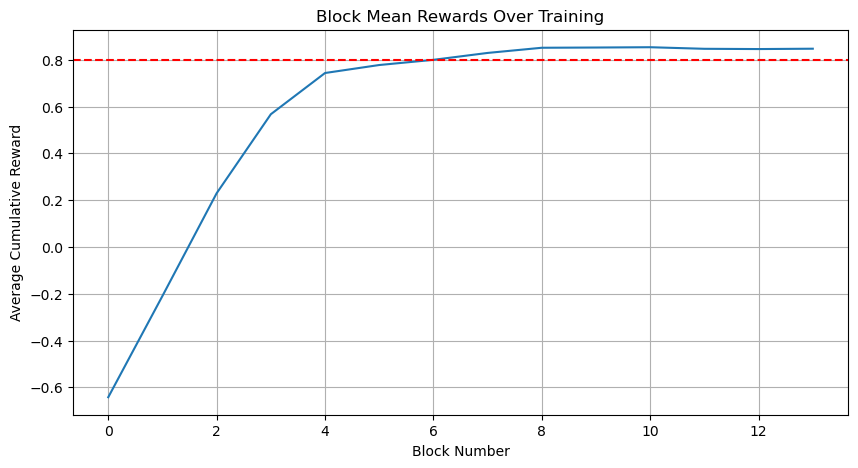

Mean of the last 7000 trials' cumulative rewards: 0.8247805817276934


In [102]:
L = 10
mdp = MDPLanding(L)
Q_values, rewards = q_learning(mdp, 7000)  #7-8000 episode is enough to converge ~.8

block_size = 500
block_means = [np.mean(rewards[i:i + block_size]) for i in range(0, len(rewards), block_size)]

plt.figure(figsize=(10, 5))
plt.plot(block_means)
plt.title("Block Mean Rewards Over Training")
plt.axhline(y=0.8, color='red', linestyle='--', label='Target Mean Reward')
plt.xlabel("Block Number")
plt.ylabel("Average Cumulative Reward")
plt.grid(True)
plt.show()

last_mean_reward = np.mean(rewards[-5000:])
print("Mean of the last 7000 trials' cumulative rewards:", last_mean_reward)


#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

***Question 1:*** The cumulative reward starts around -0.5 (or -.06 in my case, started this really late) at the beginning of the training because the drone doesn't know where to go initially. So it gets lost and often ends up in states where it gets small penalties, adding up to a negative total.



***Question 2:*** It will be hard for the drone to consistently get rewards much higher than 0.8 because the environment is uncertain, and the rewards for reaching the landing pad are rare. Also, as time goes on, future rewards become less important to the drone. So, consistently achieving high rewards is challenging, especially if there are obstacles or limited actions available.